<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание: GAN и Style Transfer

Student: Oleg Navolotsky / Наволоцкий Олег  
Stepik: https://stepik.org/users/2403189  
Telegram: [@mehwhatever0](https://t.me/mehwhatever0)

**Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

Some used software versions:
- Pytorch 1.7.0
- Torchvision 0.8.1
- NumPy 1.18.5
- Python 3.8.3 (default, Jul  2 2020, 17:30:36) \[MSC v.1916 64 bit (AMD64)] :: Anaconda, Inc. on win32
- NVIDIA Driver 460.79
- NVIDIA CUDA 11.1
- Windows 10 Pro 1909, build 18363.535

Hardware:
- i5 2500 8 gb
- GTX 1060 6 gb

In [1]:
import os
import random

import numpy as np
import torch


SEED = 0


def enable_reproducibility(seed=SEED, raise_if_no_deterministic=True, cudnn_deterministic=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    if raise_if_no_deterministic:
        torch.set_deterministic(True)

    torch.manual_seed(seed)
    if cudnn_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"


### References
1. [link](https://arxiv.org/abs/1703.10593) Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, 2017.
2. [link](https://arxiv.org/abs/1603.08155) J. Johnson, A. Alahi, and L. Fei-Fei. Perceptual losses for real-time style transfer and super-resolution. In ECCV, 2016.
3. [link](https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf) J. Johnson, A. Alahi, and L. Fei-Fei. Perceptual losses for real-time style transfer and super-resolution: Supplementary Material.
4. [link](https://arxiv.org/abs/1611.07004) P. Isola, J.-Y. Zhu, T. Zhou, and A. A. Efros. Image-to-image translation with conditional adversarial networks. In CVPR, 2017.

# Воспроизведение существующей задачи
Я выбрал вариант с CycleGAN: выполню имплементацию, базируясь на оригинальной статье, и попробую выполнить object transfiguration на *apple* и *navel orange* из **ImageNet**.

## Generator achitectures
В качестве основы для архитектуры генераторов авторы CycleGAN позаимствовали архитектуру сети для style transfer из \[2] (описана в \[3]).

Внесенные ими изменения описаны в разделе \[1] _7.2. Network architectures_. Отличия заключаются в количестве residual blocks, размере ядер и количестве фильтров сверток. Также после сверток вместо batch normalization использутся instance normalization. В residual blocks увеличено количество фильтров и, по-видимому, тоже заменена нормализация.

Предложено два варианта, в зависимости от размера входных изображений: для разрешения 128x128 (6 residual blocks), а также для 256x256 и выше (9 residual blocks). Здесь мы используем второй вариант.

## Discriminator architectures
За основу взят PatchGAN 70x70, описанный в предыдущий работе авторов (pix2pix \[4]), заменена нормализация.

Принцип действия следующий: несколько сверточных слоев идут друг за другом, более глубокие имеют все большее поле восприятия. Последний слой переводит все карты признаков в одну, которая является по сути набором "заплаток", поскольку каждый "пиксель" в ней соответствует участку исходного изображения. Эта карта признаков есть выход дискриминатора, который подается в сигмоиду и получившиеся числа трактуются как вероятности того, что соотвествующие заплатки являются частями истинной (не фейковой) картинки. За сам ответ дискриминатора принимается среднее выхода сигмоды по всем заплаткам.

Интересно, что сами числа 70x70 в статьей не объясняются (они получаются неявно как результат последовательности сверток) и интересующимся приходится задавать вопросы в github-репозитории авторов. Не добавляет ясности и то, что в статье не указан stride для выходного сверточного слоя, а также некорректно указан stride для предпоследнего слоя. В ответе на [issue](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/162) авторы обещали исправить досадное упущение в очередной редакции статьи, но не сделали этого: в последней редакции статьи, вышедшей уже после issue всё осталось по-старому.

In [2]:
# CycleGAN architecture from scratch implementation based on the original paper.
# [CycleGAN, 24 Aug 2020, 7th revision] Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks
# https://arxiv.org/pdf/1703.10593.pdf


from torch import nn


class CycleGANGenerator(nn.Module):
    def __init__(self, res_num=9):
        super().__init__()
        # c7s1-64
        # Using bias before normalization is meaningless,
        # but authors of the reference implementation do:
        # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/f13aab8148bd5f15b9eb47b690496df8dadbab0c/models/networks.py#L551
        # Thanks god, I am not the only one who noticed this:
        # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/981
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7,
                      stride=1, padding=3, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        # d128
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                      stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        # d256
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,
                      stride=2, padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        # R256 x res_num
        self.residuals = nn.ModuleList(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256,
                          kernel_size=3, padding=1, bias=False),
                nn.InstanceNorm2d(num_features=256),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=256, out_channels=256,
                          kernel_size=3, padding=1, bias=False),
                nn.InstanceNorm2d(num_features=256)
            )
            for _ in range(res_num)
        )
        # u128
        self.conv4 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv4_norm_act = nn.Sequential(
            nn.InstanceNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        # u64
        self.conv5 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5_norm_act = nn.Sequential(
            nn.InstanceNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        # c7s1-3
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7,
                      stride=1, padding=3, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        output = self.conv1(input)
        conv1_output_size = output.size()
        output = self.conv2(output)
        conv2_output_size = output.size()
        output = self.conv3(output)
        for residual in self.residuals:
            output = residual(output) + output
        output = self.conv4(output, output_size=conv2_output_size)
        output = self.conv4_norm_act(output)
        output = self.conv5(output, output_size=conv1_output_size)
        output = self.conv5_norm_act(output)
        output = self.conv6(output)
        return output


class CycleGANDiscriminator(nn.Module):  # PatchGAN 70x70
    def __init__(self):
        super().__init__()
        # C64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        # C128
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        # C256
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        # C512
        # Stride for this layer and the last one is 1:
        # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/162
        # This is missed in the paper and they haven't still fixed this.
        # I was damn confused by this missing when trying to implement from scratch
        # basing just on the original paper with no any look in the reference implementation.
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.output = nn.Conv2d(
            in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.output(output)
        return output


class CycleGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.forward_generator = CycleGANGenerator()
        self.backward_generator = CycleGANGenerator()
        self.forward_discriminator = CycleGANDiscriminator()
        self.backward_discriminator = CycleGANDiscriminator()

    def forward(self, input, target):
        generated_from_input = self.forward_generator(input)
        reconstructed_input = self.backward_generator(generated_from_input)
        generated_from_target = self.backward_generator(target)
        reconstructed_target = self.forward_generator(generated_from_target)
        forward_discriminator_output_on_generated_from_input = self.forward_discriminator(
            generated_from_input)
        forward_discriminator_output_on_target = self.forward_discriminator(
            target)
        backward_discriminator_output_on_generated_from_target = self.backward_discriminator(
            generated_from_target)
        backward_discriminator_output_on_input = self.backward_discriminator(
            input)
        return (generated_from_input, reconstructed_input,
                generated_from_target, reconstructed_target,
                forward_discriminator_output_on_generated_from_input,
                forward_discriminator_output_on_target,
                backward_discriminator_output_on_generated_from_target,
                backward_discriminator_output_on_input)


## Losses: adversarial, cycle consistency, identity mapping
Лоссы в статье описаны довольно подробно. Adversarial loss, который дискриминатор и генератор должны перетягивать в свою сторону, на практике заменяется на два отдельных, каждый из которых предназачен для минизации в процессе обучения дискриминатора или генератора.

К сожалению, реализовать это элегантным способ не удается: для корректного использования лосса, т.е. дальнейшего корректного backpropagation градиента лосса приходится применять сразу несколько (на мой взгляд) костылей в цикле обучения: заморозка весов дискриминатора/генератора и `retain_graph=True`. Их необходимость вызвана тем, что графы вычислений градиента по весам дискриминатора и генератора имеют общую вершину $ D(G(x))$.

Можно придумать и другие костыли, которые не потребуют телодвижений в имплементации лосса и цикла обучения, но зато приведут к увеличению количества вычислений и дополнительному потреблению памяти: поочередный `.detach()` сначала для $G(x)$, потом для всех весов $D$, а затем повторный прогон дискриминатора после этих `.detach()`.

Еще один интересный момент, в котором пока не удалось разобраться: обычно в **PyTorch** при попытке повторного `.backward()` по вершине без `retain_graph=True` в предыдущем `.backward()` возникает исключение, явно описывающее ошибку и необходимость `retain_graph=True`. У меня ситуация вроде бы должна быть идентичной: есть общая вершина (тензор $D(G(x)$)) и два `.backward()` для, соответственно, распространения градиента по весам сначала генератора (дискриминатор заморожен) и весам дискриминатора (генератор заморожен). Если при первом `.backward()` не указать `retain_graph=True`, то `.grad` весов дискриминатора останется `None` без возникновения какого-либо `Exception` или `Warning`. Да, головы у графов разные, но ведь есть общая вершина и по ней повторно идет распространение градиента. Возможно, как-то влияет заморозка весов, но игры в REPL **IPython**'а с аналогичной ситуацей, но упрощенной до нескольких тензоров, подобное поведение воспроизвести не помогли: исключение возникает, как и должно.

In [3]:
import torch
from torch import nn


class AdversarialLoss(nn.Module):
    def forward(
            self,
            discriminator_output_on_fake,
            discriminator_output_on_real):
        probs_on_fake = torch.sigmoid(
            discriminator_output_on_fake).mean((-2, -1))
        probs_on_real = torch.sigmoid(
            discriminator_output_on_real).mean((-2, -1))
        gen_term = torch.mean((probs_on_fake - 1) ** 2)
        dis_term = torch.mean(probs_on_fake ** 2) + \
            torch.mean((probs_on_real - 1) ** 2)
        return gen_term, dis_term


class OneDirectionCycleConsistencyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.L1Loss(reduction='mean')

    def forward(self, input, reconstructed_input):
        loss = self._loss(input, reconstructed_input)
        return loss


class CycleConsistencyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.one_direction_loss = OneDirectionCycleConsistencyLoss()

    def forward(self, input, reconstructed_input, target, reconstructed_target):
        return (
            self.one_direction_loss(input, reconstructed_input) +
            self.one_direction_loss(target, reconstructed_target))


class IdentityMappingLoss:
    def __init__(self):
        super().__init__()
        self._loss = nn.L1Loss(reduction='mean')

    def forward(self, input, generated_from_input, target, generated_from_target):
        return (self._loss(input, generated_from_input) + self._loss(target, generated_from_target))


class CycleGANLoss(nn.Module):
    # I wanted to implement this in more intelligent way,
    # but this feature (detach for model weights) is not implemented so far:
    # https://discuss.pytorch.org/t/how-to-use-a-layer-with-gradient-but-without-weight-adjustment/86190

    """
    To use it correctly, you must manually freeze
    discriminators parameters when backpropagating generators losses
    and freeze generators parameters when backpropagating discriminators losses.
    """

    def __init__(
        self,
        cycle_consistency_weight=10,  # aka lambda
        include_identity_loss=False,  # used for some specific applications
        # results in given value * lambda:
        identity_loss_fraction_from_cycle_consistency_weight=0.5
    ):
        super().__init__()
        self.adversarial_loss = AdversarialLoss()
        self.cycle_consistency_loss = CycleConsistencyLoss()
        self.cyc_weight = cycle_consistency_weight
        self.include_identity_loss = include_identity_loss
        if include_identity_loss:
            self.identity_mapping_loss = IdentityMappingLoss()
        self.id_fraction_from_cyc_weight = identity_loss_fraction_from_cycle_consistency_weight

    def forward(
        self,
        input, target,
        generated_from_input, reconstructed_input,
        generated_from_target, reconstructed_target,
        forward_discriminator_output_on_generated_from_input,
        forward_discriminator_output_on_target,
        backward_discriminator_output_on_generated_from_target,
        backward_discriminator_output_on_input
    ):
        fgen_loss, fdis_loss = self.adversarial_loss(
            forward_discriminator_output_on_generated_from_input,
            forward_discriminator_output_on_target
        )
        bgen_loss, bdis_loss = self.adversarial_loss(
            backward_discriminator_output_on_generated_from_target,
            backward_discriminator_output_on_input
        )
        cyc_loss = self.cycle_consistency_loss(
            input, reconstructed_input,
            target, reconstructed_target
        )
        weighted_cyc_loss = self.cyc_weight * cyc_loss
        losses = [fgen_loss, fdis_loss, bgen_loss,
                  bdis_loss, weighted_cyc_loss]
        if self.include_identity_loss:
            id_loss = self.identity_loss(
                input, generated_from_input,
                target, generated_from_target
            )
            weighted_id_loss = self.id_fraction_from_cyc_weight * self.cyc_weight * id_loss
            losses.append(weighted_id_loss)
        return losses


## Training Loop
Ну и раз уж обсудили "трейнлуп" (кстати, такой [запрос](https://www.google.com/search?q="трейнлуп") в Гугле дает лишь несколько результатов, а думал, что это общеупотребимый жаргонизм), то вот код:

In [4]:
import os
import uuid
from itertools import chain

import torch
from torch.nn import Module
from tqdm import tqdm



def freeze_all_params(params):
    for param in params:
        param.requires_grad = False


def unfreeze_all_params(params):
    for param in params:
        param.requires_grad = True


class WeightsFreezer:
    """
    Context manager which freezes given params.

    Args:
        it: model, models iterable, params iterable
    """

    def __init__(self, it):
        if isinstance(it, Module):
            self.params = list(it.parameters())
        else:
            self.params = []
            for el in iter(it):
                if isinstance(el, Module):
                    self.params.extend(el.parameters())
                else:
                    self.params.append(el)

    def __enter__(self):
        freeze_all_params(self.params)
        return self.params

    def __exit__(self, exc_type, exc_value, traceback):
        unfreeze_all_params(self.params)
        return self.params



def get_last_created_file(dir_path, file_ext) -> os.DirEntry:
    files = [entry for entry in os.scandir(
        dir_path) if entry.is_file() and entry.name.lower().endswith(file_ext)]
    files.sort(key=lambda x: x.stat().st_ctime_ns)
    return files[-1] if files else None


def delete_files_except_last_created(dir_path, file_ext, files_num_to_retain, stride='auto'):
    files = [entry for entry in os.scandir(
        dir_path) if entry.is_file() and entry.name.lower().endswith(file_ext)]
    files.sort(key=lambda x: x.stat().st_ctime_ns)
    files_len_ = len(files)
    if stride == 'auto':
        stride = max(files_len_ // files_num_to_retain, 1)
    inds_to_retain = []
    for stride_num in range(files_num_to_retain):
        i = -1 - stride_num * stride
        if i < -files_len_:
            i = -files_len_
        inds_to_retain.append(i + files_len_)
    for i, file in enumerate(files):
        if i not in inds_to_retain:
            os.remove(file.path)


class CheckpointDirectoryEmpty(ValueError):
    pass


class Trainer:
    _predefined_attrs = (
        'train_checkpoints_dir',
        'checkpoint_name_pattern',
        'model_final_chekpoint_name_template',
        'retain_only_num_checkpoints',
        'checkpoints_saving_stride',
        '_state_attr_names',
        '_training_state'
    )

    def __init__(
            self,
            train_checkpoints_dir='./model_training_checkpoints',
            checkpoint_name_template="checkpoint_{uuid}",
            model_final_chekpoint_name_template="trained_model_final_state",
            retain_only_num_checkpoints=None,
            checkpoints_saving_stride='auto',
            **kwargs):
        self.train_checkpoints_dir = train_checkpoints_dir
        self.checkpoint_name_pattern = checkpoint_name_template
        self.model_final_chekpoint_name_template = model_final_chekpoint_name_template
        self.retain_only_num_checkpoints = retain_only_num_checkpoints
        self.checkpoints_saving_stride = checkpoints_saving_stride
        self._state_attr_names = set(kwargs.keys())
        self._training_state = kwargs

    def __getattr__(self, name):
        if name in self._state_attr_names:
            return self._training_state[name]
        else:
            raise AttributeError

    def __setattr__(self, name, value):
        if name in self._predefined_attrs:
            return super().__setattr__(name, value)
        else:
            self._state_attr_names.add(name)
            self._training_state[name] = value

    def save_state(self):
        state_dict = {}
        for key, val in self._training_state.items():
            typ = type(val)
            # second condition is a kludge for saving criterion with parameters
            if hasattr(val, 'state_dict') and val.state_dict():
                val = val.state_dict()
            state_dict[key] = (typ, val)
        if self.checkpoint_name_pattern == "checkpoint_{uuid}":
            checkpoint_name = self.checkpoint_name_pattern.format(
                uuid=uuid.uuid4().hex)
        else:
            checkpoint_name = self.checkpoint_name_pattern.format(
                **self._training_state)
        checkpoint_name += ".tar"
        os.makedirs(self.train_checkpoints_dir, exist_ok=True)
        checkpoint_path = os.path.join(
            self.train_checkpoints_dir, checkpoint_name)
        torch.save(state_dict, checkpoint_path)

    def save_model(self, *, model_attr_name='model'):
        checkpoint_name = self.model_final_chekpoint_name_template
        if self.model_final_chekpoint_name_template != "trained_model_final_state":
            checkpoint_name = self.model_final_chekpoint_name_template.format(
                **self._training_state)
        checkpoint_name += ".pt"
        os.makedirs(self.train_checkpoints_dir, exist_ok=True)
        checkpoint_path = os.path.join(
            self.train_checkpoints_dir, checkpoint_name)
        torch.save(getattr(self, model_attr_name).state_dict(), checkpoint_path)

    def load_state(self, path=None):
        self._training_state.clear()
        if path is None:
            try:
                last_checkpoint = get_last_created_file(
                    self.train_checkpoints_dir, '.tar')
            except FileNotFoundError:
                os.makedirs(self.train_checkpoints_dir, exist_ok=True)
                last_checkpoint = None
            if last_checkpoint is None:
                raise CheckpointDirectoryEmpty(
                    "checkpoint directory is empty: ", self.train_checkpoints_dir)
            path = last_checkpoint.path
        state_dict = torch.load(path)
        self._convert_state_dict_to_internal_state(state_dict)
        self._state_attr_names = set(self._training_state.keys())

    def _convert_state_dict_to_internal_state(self, state_dict):
        special_cases = ('model', 'gen_optimizer', 'dis_optimizer')
        for key, (typ, val) in state_dict.items():
            if key not in special_cases:
                setattr(self, key, val)
        typ, val = state_dict['model']
        self.model = model = typ()
        model.load_state_dict(val)
        model.to(self.device)
        typ, val = state_dict['gen_optimizer']
        self.gen_optimizer = gen_optimizer = typ(chain(
            model.forward_generator.parameters(),
            model.backward_generator.parameters()
        ))
        gen_optimizer.load_state_dict(val)
        typ, val = state_dict['dis_optimizer']
        self.dis_optimizer = dis_optimizer = typ(chain(
            model.forward_discriminator.parameters(),
            model.backward_discriminator.parameters()
        ))
        dis_optimizer.load_state_dict(val)

    def run(self):
        losses = getattr(self, 'loss_by_epochs', None)
        if losses is None:
            losses = []
            setattr(self, 'loss_by_epochs', losses)
        
        model = self.model
        was_training = model.training
        model.train()
        
        generators_parameters = [
            *model.forward_generator.parameters(),
            *model.backward_generator.parameters()
        ]

        discriminators_parameters = [
            *model.forward_discriminator.parameters(),
            *model.backward_discriminator.parameters()
        ]
        
        X_len, Y_len = len(self.X_loader), len(self.Y_loader)
        batches_num = max(X_len, Y_len)
        def get_X_iter(): return iter(self.X_loader)
        def get_Y_iter(): return iter(self.Y_loader)
        if X_len > Y_len:
            # pylint: disable=function-redefined
            def get_Y_iter(): return chain(
                *[iter(self.Y_loader) for _ in range(X_len // Y_len + 1)])
        elif X_len < Y_len:
            # pylint: disable=function-redefined
            def get_X_iter(): return chain(
                *[iter(self.X_loader) for _ in range(Y_len // X_len + 1)])

        epoch = getattr(self, 'epoch', -1) + 1
        postfix_kwargs = {'loss': losses[-1] if losses else None}
        with tqdm(range(epoch, self.epochs), initial=epoch, total=self.epochs, desc="epochs", postfix={'loss': losses[-1] if losses else None}) as pbar:
            for self.epoch in pbar:
                epoch_cum_loss = 0
                for j, (X_batch, Y_batch) in tqdm(enumerate(zip(get_X_iter(), get_Y_iter())), total=batches_num, desc="batches"):
                    X_batch = X_batch.to(self.device)
                    Y_batch = Y_batch.to(self.device)
                    self.gen_optimizer.zero_grad()
                    model_output = model(X_batch, Y_batch)
                    (
                        fgen_loss, fdis_loss,
                        bgen_loss, bdis_loss,
                        cyc_loss
                    ) = self.criterion(X_batch, Y_batch, *model_output)
                    gens_loss = fgen_loss + bgen_loss + cyc_loss
                    diss_loss = fdis_loss + bdis_loss
                    with freezed(discriminators_parameters):
                        # retain_graph=True is required because
                        # a computation graph node is shared between gen and dis:
                        gens_loss.backward(retain_graph=True)
                    with freezed(generators_parameters):
                        diss_loss.backward()
                    loss = gens_loss + diss_loss
                    epoch_cum_loss += loss.item()
                    self.gen_optimizer.step()
                    if (j + 1) % self.batches_per_discriminators_update == 0:
                        self.dis_optimizer.step()
                        self.dis_optimizer.zero_grad()
                if batches_num % self.batches_per_discriminators_update != 0:
                    self.dis_optimizer.step()
                    self.dis_optimizer.zero_grad()
                postfix_kwargs['loss'] = epoch_mean_loss = epoch_cum_loss / batches_num
                pbar.set_postfix(postfix_kwargs)
                losses.append(epoch_mean_loss)
                self.save_state()
                if self.retain_only_num_checkpoints is not None:
                    delete_files_except_last_created(
                        self.train_checkpoints_dir,
                        '.tar',
                        self.retain_only_num_checkpoints,
                        self.checkpoints_saving_stride
                    )
        self.save_model(model_attr_name='model')
        model.train(was_training)


## Dataset
C датасетом возникла засада: *apple* и *navel orange* из **ImageNet** получить не удалось, поскольку по этим запросам и по многим другим он выдает (17.01.2021) следующее:
> ImageNet is under maintenance. Only ILSVRC synsets are included in the search results.

Зато  доступны *banana* и *cucumber*: что ж, попытаемся превратить бананы в огурцы и наоборот.

По *banana* **ImageNet** выдал 1409 ссылок — скачать валидных изображений удалось 1046, по *cucumber* выдал 1262 — скачать удалось 872. Из обоих наборов случаным образом было отделено по 50 изображений в тестовую часть. Остальные использовались для обучения, на вход модели подавалось одно изображение из *banana* и одно из *cucumber*: в forward генераторе (реальные) и backward дискриминаторе (реальные и фейковые) бананы были входом, а в backward генераторе и forward дискриминаторе им были огурцы.

Итого, модель обучалась на 996 изображениях бананов и 822 изображениях огурцов. Батч состоял из одной пары (banana, cucumber), и поскольку первых больше, чем вторых, то некоторые изображения огурцов модель за эпоху видела больше одного раза. Всего 996 батчей/эпоха.

Датасет доступен в папке `./datasets`. Код для отделения тестовой части и класс для использования в `DataLoader`:

In [5]:
import os
import random
import shutil

from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader, IMG_EXTENSIONS


class ImagesDataset(Dataset):
    def __init__(self, root, transform=None, loader=default_loader, extensions=IMG_EXTENSIONS):
        super().__init__()
        self.root = root
        self.transform = transform
        self.loader = loader
        self.extensions = extensions
        self._img_paths = [
            entry.path for entry in os.scandir(root) if entry.is_file() and entry.name.lower().endswith(self.extensions)
        ]

    def __getitem__(self, key):
        path = self._img_paths[key]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self._img_paths)


def split_folder(path, train_path, test_path, test_num):
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    files = [entry for entry in os.scandir(path) if entry.is_file()]
    random.shuffle(files)
    for i, file in enumerate(files):
        target_dir = test_path if i < test_num else train_path
        new_path = os.path.join(target_dir, file.name)
        shutil.move(file.path, new_path)


if __name__ == "--not-now--":
    import random
    random.seed(SEED)

    for dataset_name in ('cucumber', 'banana'):
        TEST_NUM = 50
        os.chdir(os.path.abspath('./hw_cycle_gan_from_scratch'))
        path = f"./datasets/{dataset_name}"
        train_path = f"{path}/train"
        test_path = f"{path}/test"
        split_folder(path, train_path, test_path, TEST_NUM)


## Training model
Обучим модель:

In [6]:
import os
from itertools import chain

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

if __name__ == "--not-now--":
    os.chdir(os.path.abspath('./hw_cycle_gan_from_scratch'))

    import logging
    import sys

    logger = logging.getLogger("training")
    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        fmt="%(asctime)s - %(levelname)s - %(message)s")
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    file_handler = logging.FileHandler(
        "./training_log.txt", mode='a', encoding='utf-8')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    CHEKPOINTS_DIR = "./cycle_gan_training_checkpoints"
    CHECKPOINT_NAME_TEMPLATE = "checkpoint_epoch_{epoch}"
    MODEL_FINAL_CHEKPOINT_NAME_TEMPLATE = "model_final_chekpoint"
    RETAIN_ONLY_NUM_CHECKPOINTS = 5

    trainer = Trainer(CHEKPOINTS_DIR, CHECKPOINT_NAME_TEMPLATE,
                      MODEL_FINAL_CHEKPOINT_NAME_TEMPLATE, RETAIN_ONLY_NUM_CHECKPOINTS)
    try:
        trainer.load_state()
        logger.info("Previous state loading succeeded.")
    except CheckpointDirectoryEmpty:
        logger.info(
            "Previous state loading failed: checkpoint folder is empty. Training from scratch.")
        X_dataset_path = "datasets/banana/train"
        Y_dataset_path = "datasets/cucumber/train"

        IMAGE_SMALLER_EDGE_SIZE = 256
        BATCH_SIZE = 1
        NUM_WORKERS = 0
        STAGE_1_EPOCHS = 100
        STAGE_1_LR = 2e-4
        STAGE_2_EPOCHS = 100
        BATCHES_PER_DISCRIMINATORS_UPDATE = 50  # image buffer in the paper

        transform = transforms.Compose([
            transforms.Resize(
                (IMAGE_SMALLER_EDGE_SIZE, IMAGE_SMALLER_EDGE_SIZE)),
            transforms.ToTensor()
        ])

        X_dataset = ImagesDataset(X_dataset_path, transform=transform)
        Y_dataset = ImagesDataset(Y_dataset_path, transform=transform)

        # raise_if_no_deterministic causes:
        # Exception has occurred: RuntimeError
        # reflection_pad2d_backward_cuda does not have a deterministic implementation,
        # but you set 'torch.set_deterministic(True)'. You can turn off determinism just for this operation if that's acceptable for your application.
        # You can also file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation.
        # ------------
        # cudnn_deterministic=True causes Unable to find a valid cuDNN algorithm to run convolution
        enable_reproducibility(raise_if_no_deterministic=False,
                               cudnn_deterministic=False)

        X_loader = DataLoader(X_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        Y_loader = DataLoader(Y_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = CycleGAN().to(DEVICE)

        criterion = CycleGANLoss()

        generators_optimizer = Adam(
            chain(
                model.forward_generator.parameters(),
                model.backward_generator.parameters()
            ), lr=STAGE_1_LR)
        discriminators_optimizer = Adam(
            chain(
                model.forward_discriminator.parameters(),
                model.backward_discriminator.parameters()
            ), lr=STAGE_1_LR)

        trainer = Trainer(CHEKPOINTS_DIR, CHECKPOINT_NAME_TEMPLATE,
                          MODEL_FINAL_CHEKPOINT_NAME_TEMPLATE, RETAIN_ONLY_NUM_CHECKPOINTS,
                          model=model, X_loader=X_loader, Y_loader=Y_loader, criterion=criterion,
                          gen_optimizer=generators_optimizer, dis_optimizer=discriminators_optimizer,
                          epochs=STAGE_1_EPOCHS, batches_per_discriminators_update=BATCHES_PER_DISCRIMINATORS_UPDATE, device=DEVICE)

    runs = 0
    max_tries = 3
    while True:
        runs += 1
        try:
            if runs == 1:
                logger.info("Training started.")
            else:
                logger.info("Training restarted: run try %s/%s.",
                            runs, max_tries)
            trainer.run()
            logger.info("Training seems to be successfully finished.")
            break
        except Exception:
            logger.exception("Some error appeared during training.")
            if runs >= max_tries:
                logger.error(
                    "All %s run tries exceeded. Stopping process.", max_tries)
                sys.exit(1)
            try:
                trainer.load_state()
                logger.info("Training state reloading succeeded.")
            except CheckpointDirectoryEmpty:
                pass
    trainer.save_state()
    logger.info("Final state saving succeeded.")


## Inference
Проверим обученную модель на тестовой части. Результаты будут сохранены в `./inference_result`.

In [7]:
import os

import torch
from torch.utils.data import DataLoader
from torchvision import transforms


def load_model(checkpoint_path, *, checkpoint_type='state_dict', state_dict_model_key='model', device='cuda'):
    device = torch.device(device)
    if checkpoint_type == 'state_dict':
        model = CycleGAN()
        state_dict = torch.load(checkpoint_path)
        model.load_state_dict(state_dict)
    elif checkpoint_type == 'entire_model':
        model = torch.load(checkpoint_path)
    elif checkpoint_type == 'general':
        model = CycleGAN()
        state_dict = torch.load(checkpoint_path)
        try:
            state_dict = state_dict[state_dict_model_key][1]
        except KeyError:
            raise ValueError(
                f"no such state_dict_model_key='{state_dict_model_key}' in given state_dict")
        model.load_state_dict(state_dict)
    else:
        raise ValueError(
            'checkpoint_type must be on of ("state_dict", "entire_model", "general")')
    return model.to(device)


def get_data_loader(
        data_dir, dataset_cls=ImagesDataset, transform=transforms.ToTensor(),
        batch_size=1, shuffle=False, num_workers=0, pin_memory=False):
    dataset = dataset_cls(data_dir, transform=transform)
    data_loader = DataLoader(
        dataset, batch_size=batch_size,
        shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
    return data_loader


@torch.no_grad()
def do_tranformations(model, data_loader, output_dir, direction='forward', device='cuda'):
    device = torch.device(device)
    was_training = model.training
    model.eval()
    to_pil = transforms.ToPILImage()
    image_name_teplate = "image_{image_num:0>" + \
        str(len(str(len(data_loader.dataset)))) + "}"
    image_path_template = os.path.join(output_dir, image_name_teplate)
    if direction == 'forward':
        fgen = model.forward_generator
        bgen = model.backward_generator
    elif direction == 'backward':
        fgen = model.backward_generator
        bgen = model.forward_generator
    else:
        raise ValueError('direction must be "forward" or "backward"')
    image_num = -1
    for batch in data_loader:
        batch = batch.to(device)
        transformed = fgen(batch)
        reconstructed = bgen(transformed)
        for o, t, r in zip(batch, transformed, reconstructed):
            image_num += 1
            image_path = image_path_template.format(image_num=image_num)
            to_pil(o).save(image_path + "_0_original.jpg")
            to_pil(t).save(image_path + "_1_transformed.jpg")
            to_pil(r).save(image_path + "_2_reconstructed.jpg")
    model.train(was_training)


def main(checkpoint_file,
         checkpoint_dir="cycle_gan_training_checkpoints",
         checkpoint_type='general',
         resize_size=(256, 256)
         ):
    # model
    checkpoint_path = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        checkpoint_dir,
        checkpoint_file
    )
    model = load_model(
        checkpoint_path=checkpoint_path,
        checkpoint_type=checkpoint_type
    )

    transform = transforms.Compose(
        [transforms.Resize(resize_size), transforms.ToTensor()]
    )

    # banana -> cucumber
    data_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "datasets/banana/test"
    )
    output_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "inference_result/banana-to-cucumber/test"
    )
    os.makedirs(output_dir, exist_ok=True)
    data_loader = get_data_loader(data_dir, transform=transform)
    do_tranformations(model, data_loader,
                      output_dir,
                      direction='forward')

    # cucumber -> banana
    data_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "datasets/cucumber/test"
    )
    output_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "inference_result/cucumber-to-banana/test"
    )
    os.makedirs(output_dir, exist_ok=True)
    data_loader = get_data_loader(data_dir, transform=transform)
    do_tranformations(model, data_loader,
                      output_dir,
                      direction='backward')


if __name__ == "--not-now--":
    main("checkpoint_epoch_31.tar")

Код выше сохраняет результаты в папку. Взглянем на результаты здесь, в ноутбуке.

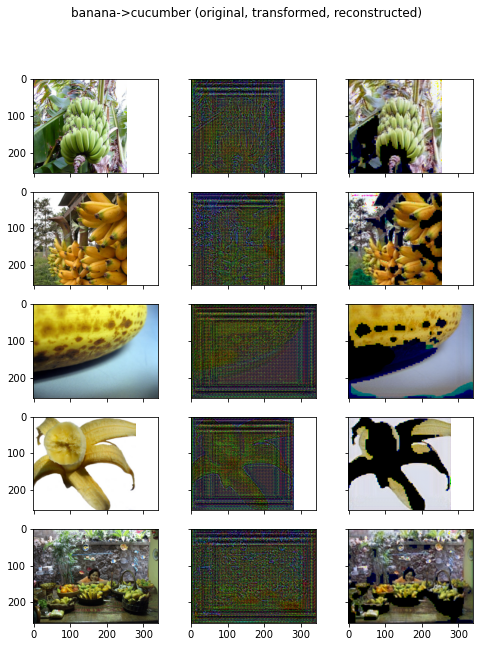

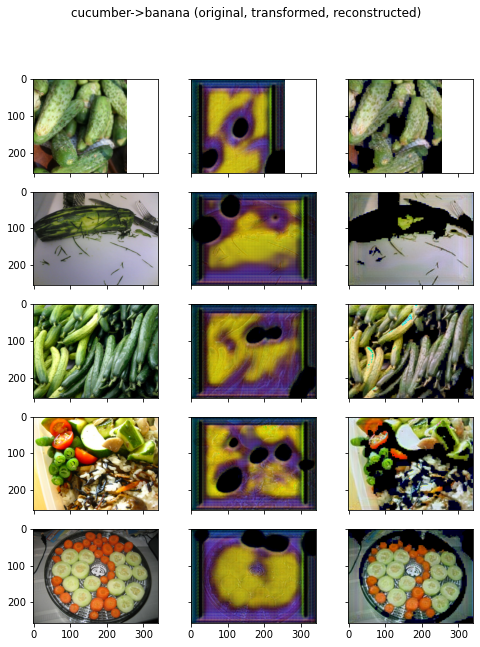

In [8]:
import torch
from matplotlib import pyplot as plt


@torch.no_grad()
def inference_and_plot(model, data_loader, how_many_results_per_cls, title, direction='forward', device='cuda'):
    device = torch.device(device)
    was_training = model.training
    model.eval()
    to_pil = transforms.ToPILImage()
    if direction == 'forward':
        fgen = model.forward_generator
        bgen = model.backward_generator
    elif direction == 'backward':
        fgen = model.backward_generator
        bgen = model.forward_generator
    else:
        raise ValueError('direction must be "forward" or "backward"')
    image_num = -1
    fig, axes = plt.subplots(
        nrows=how_many_results_per_cls, ncols=3,
        figsize=(8, 2 * how_many_results_per_cls), 
        sharey=True, sharex=True)
    fig.suptitle(title)
    image_num = 0
    for i, batch in enumerate(data_loader):
        if i >= how_many_results_per_cls:
            break
        batch = batch.to(device)
        transformed = fgen(batch)
        reconstructed = bgen(transformed)
        for o, t, r in zip(batch, transformed, reconstructed):
            image_num += 1
            axes[i][0].imshow(to_pil(o))
            axes[i][1].imshow(to_pil(t))
            axes[i][2].imshow(to_pil(r))
    model.train(was_training)


def show_some_resuls(
            checkpoint_file,
            checkpoint_dir="cycle_gan_training_checkpoints",
            checkpoint_type='general',
            resize_size=(256, 256),
            how_many_results_per_cls=5,
            ):
    # model
    checkpoint_path = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        checkpoint_dir,
        checkpoint_file
    )
    model = load_model(
        checkpoint_path=checkpoint_path,
        checkpoint_type=checkpoint_type
    )

    transform = transforms.Compose(
        [transforms.Resize(resize_size), transforms.ToTensor()]
    )

    # banana -> cucumber
    data_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "datasets/banana/test"
    )
    output_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "inference_result/banana-to-cucumber/test"
    )
    os.makedirs(output_dir, exist_ok=True)
    data_loader = get_data_loader(data_dir, transform=transform)
    inference_and_plot(model, data_loader,
                       how_many_results_per_cls,
                       "banana->cucumber (original, transformed, reconstructed)",
                       direction='forward')

    # cucumber -> banana
    data_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "datasets/cucumber/test"
    )
    output_dir = os.path.join(
        os.path.abspath('./hw_cycle_gan_from_scratch'),
        "inference_result/cucumber-to-banana/test"
    )
    os.makedirs(output_dir, exist_ok=True)
    data_loader = get_data_loader(data_dir, transform=transform)
    inference_and_plot(model, data_loader,
                       how_many_results_per_cls,
                       "cucumber->banana (original, transformed, reconstructed)",
                       direction='backward')


if __name__ == "__main__":
    show_some_resuls("checkpoint_epoch_91.tar", resize_size=256)

Результаты, мягко говоря, не очень. Модель выучила крайне странное преобразование, но при этом, что удивительно, довольно успешно реконструирует из него исходное изображение. Буду разбираться с причинами.